## POS tagging using modified Viterbi

1. Data Preparation
2. Perform EDA to identify the pattern in the train set
3. Build the vanilla Viterbi based POS tagger    
    1. Evaluate the tagging acuracy with the validation set
4. Solve the problem of unknown words
    1. Technique 1 - Using a Rule tagger with the vanilla Viterbi algorithm
        1. Evaluating tagging accuracy for the algorithm using the rule tagger with simple vitrebi agorithm on the validation set
    2. Technique 2 - Using the transition probability for tagging when the emission probability is zero
        1. Evaluating tagging accuracy for the algorithm using transition probability on the validation set

5. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm
6. Find accuracy on the test set for the different Techniques used
    1.  Accuracy of simple Vitrebi on the test set
    2.  Accuracy of Rule tagger + simple Vitrebi on the test set
    3.  Accuracy of Transition probaility + simple Vitrebi on the test set

7.  Comparision of the Incorrect words across different algorithms     


### 1. Data Preparation

In [1]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import time

In [2]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\uvoc6q\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
#print (nltk_data)

In [4]:
#distribute the treebank set into train and validation sets
train_set, validation_set = train_test_split(nltk_data,train_size=0.95 ,random_state=100)
print (len (train_set))
print (len(validation_set))

3718
196


In [5]:
#write a function to extract the indiviual words in the dataset along with the tags
#get the form [(w1,t1,(w2,t2))]
def word_pos_tuple(dataset=train_set):
    word_pos = [tup for sent in dataset for tup in sent]
    return word_pos

#Write the function to get the word  from the dataset
def word_token(dataset=train_set):
    words = [tup[0] for sent in dataset for tup in sent]
    return words

def all_tags(dataset=train_set):
    word_pos = [tup[1] for sent in dataset for tup in sent]
    return word_pos

def to_sentence(dataset=train_set):
    sentence = []
    for sent in dataset:
        sentence.append(" ".join([tup[0] for tup in sent]))
    return sentence


#write functions to get the emission and transaction probability for the token
#Emission probability is (count of word marked as tag / total instance of the tag)
def word_emission(word, tag, dataset):
    word_with_tag = [tup for tup in dataset if (tup[0] == word and tup[1]== tag)]
    count_word_with_tag = len (word_with_tag)
    
    total_tag_inst = len([tup[1] for tup in dataset if tup[1] == tag])
    
    return (count_word_with_tag , total_tag_inst ) 

#calculate the transition probability
def t2_given_t1 (t2,t1,dataset):
    all_train_tag = [tup[1] for tup in dataset]
    count_t1 = len([tag for tag in all_train_tag if tag == t1])
    count_t1_t2 = 0
    for i in range (0,len(all_train_tag)-1):
        if (all_train_tag[i] == t1 and all_train_tag[i+1] == t2):
            count_t1_t2 += 1

    return (count_t1_t2 ,count_t1)                                  

In [6]:
#get the word-pos tuple for the train and validation set
train_word_tup = word_pos_tuple (train_set)
validation_word_tup = word_pos_tuple (validation_set)

In [7]:
#Get the word and token list
train_words = word_token(train_set)
train_tags = set(all_tags(train_set))

In [8]:
#Create a dataframe with the transition probabilities for the tags

tags_matrix = np.zeros((len(train_tags), len(train_tags)), dtype='float32')
for i, t1 in enumerate(list(train_tags)):
    for j, t2 in enumerate(list(train_tags)):
        tags_matrix[i, j] = t2_given_t1(t2, t1,train_word_tup)[0]/t2_given_t1(t2, t1,train_word_tup)[1]

In [9]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = train_tags, index=train_tags)
tags_df

,ADJ,PRON,PRT,DET,X,CONJ,VERB,NUM,ADV,.,ADP,NOUN
ADJ,0.067158,0.000491,0.010156,0.004914,0.020311,0.016052,0.011794,0.020803,0.004914,0.063882,0.078624,0.700901
PRON,0.072031,0.007663,0.012261,0.009195,0.092720,0.004981,0.484291,0.007280,0.034100,0.040613,0.023372,0.211494
PRT,0.083661,0.017717,0.001969,0.101050,0.013123,0.002297,0.405184,0.056102,0.010171,0.043635,0.019357,0.245735
DET,0.204977,0.003727,0.000240,0.005771,0.045323,0.000481,0.040394,0.021640,0.012623,0.017913,0.009618,0.637293
X,0.016505,0.055705,0.184891,0.055229,0.074433,0.010316,0.204571,0.002857,0.025393,0.162831,0.144898,0.062371
CONJ,0.118683,0.058414,0.003709,0.118683,0.008809,0.000464,0.155308,0.042188,0.053778,0.035698,0.053778,0.350487
VERB,0.065640,0.035916,0.031427,0.133292,0.218438,0.005186,0.168744,0.022448,0.082050,0.034291,0.091184,0.111386
NUM,0.033571,0.001485,0.026144,0.003862,0.211824,0.013072,0.016934,0.184195,0.002674,0.118835,0.035056,0.352347
ADV,0.130160,0.015646,0.014314,0.069907,0.023302,0.006991,0.344541,0.031624,0.077230,0.135153,0.119507,0.031624
.,0.043681,0.065208,0.002511,0.173558,0.026908,0.058032,0.088708,0.081353,0.052292,0.092923,0.092206,0.222531


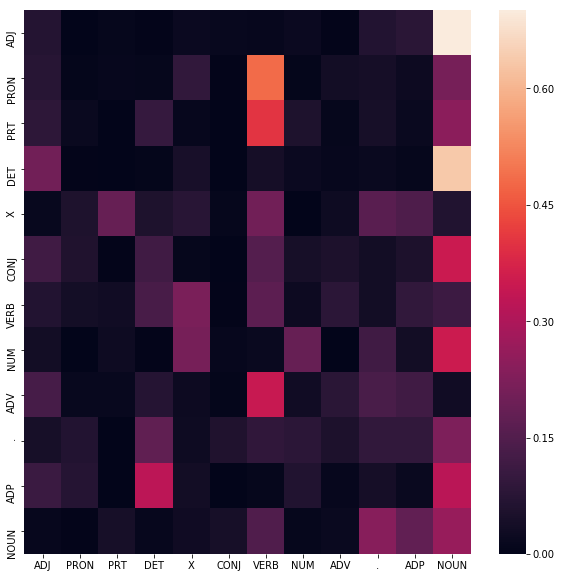

In [10]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(10, 10))
sns.heatmap(tags_df)
plt.show()

### 2. Perform EDA to identify the pattern in the train set
Look for the most common tag and the pattern across each tag
- 35% of Nouns are preceded by a Det or an adjective
- 30% of verbs end with 'ed' or 'ing'

In [11]:
#Check for the most common tag across the training dataset
from collections import Counter
all_t = all_tags()
print (Counter(all_t))       #Noun seems to be the most common tag

word_tup = word_pos_tuple()
print (len(word_tup))             #Total word-tags is 99637

tag_verb = [tag for tag in word_tup if tag[1] == 'VERB']
tag_verb_ed = [tag[0] for tag in tag_verb if tag[0].lower().endswith('ed')]
print ("Percent of words ending with ed in tags marked as VERB is {:.2%}".format(len(tag_verb_ed) / len(tag_verb)))

tag_verb_ing = [tag[0] for tag in tag_verb if tag[0].lower().endswith('ing')]
print ("Percent of words ending with ing in tags marked as VERB is {:.2%}".format(len(tag_verb_ing) / len(tag_verb)))

tag_adv_verb = [tag for i,tag in enumerate(all_t) if (tag == 'VERB' and all_t[i-1] == 'ADV')] 
print ("Number of instance a ADV is followed by Verb is {:.2%}".format(len(tag_adv_verb) / len(tag_verb)))

#adjectives followed by noun
tag_noun = [tag for tag in word_tup if tag[1] == 'NOUN']
tag_adj_noun = [tag for i,tag in enumerate(all_t) if (tag == 'NOUN' and all_t[i-1] == 'ADJ')]  
print ("Number of instance a ADJ is followed by Noun is {:.2%}".format(len(tag_adj_noun) / len(tag_noun)))

#. followed by Noun
tag_X_noun = [tag for i,tag in enumerate(word_tup) if (tag[1] == 'NOUN' and word_tup[i-1][0] == '.')]
print ("Number of instance the start of the sentence is Noun is {:.2%}".format(len(tag_X_noun) / len(tag_noun)))

#det followed by noun
tag_det_noun = [tag for i,tag in enumerate(all_t) if (tag == 'NOUN' and all_t[i-1] == 'DET')]  
print ("Number of instance a DET is followed by Noun is {:.2%}".format(len(tag_det_noun) / len(tag_noun)))


Counter({'NOUN': 27539, 'VERB': 12919, '.': 11149, 'ADP': 9433, 'DET': 8318, 'X': 6301, 'ADJ': 6105, 'NUM': 3366, 'PRT': 3048, 'ADV': 3004, 'PRON': 2610, 'CONJ': 2157})
95949
Percent of words ending with ed in tags marked as VERB is 20.61%
Percent of words ending with ing in tags marked as VERB is 10.97%
Number of instance a ADV is followed by Verb is 8.01%
Number of instance a ADJ is followed by Noun is 15.54%
Number of instance the start of the sentence is Noun is 3.62%
Number of instance a DET is followed by Noun is 19.25%


### 3. Build the vanilla Viterbi based POS tagger

In [12]:
def simple_viterbi(sent ,dataset=train_word_tup):
    #For each word in the sentence get the probaility for each unique tage and 
    #then choose the tag with the max probability
   
    unique_tags = list(set(tup[1] for tup in dataset))
    
    sent_tag = []
    prob_list = []
    for i, word in enumerate(sent):
        p_total = [] 
        for tag in unique_tags:
            if i == 0 :
                tran_p = tags_df.loc['.', tag]
            else:
                tran_p = tags_df.loc[sent_tag[i-1], tag]
                
            emission_p = word_emission(word, tag,train_word_tup)[0]/word_emission(word, tag, train_word_tup)[1]
            p_total.append(emission_p * tran_p)

        #get max probability and corresponding tag
        p_vit = max(p_total)
        prob_list.append(p_vit)
        index = p_total.index(max(p_total))
        sent_tag.append (unique_tags[index])
        
    return list(zip(sent, sent_tag , prob_list))


### 3.a Evaluate the tagging acuracy with the validation set

In [13]:
# list of tagged words
validation_tup = word_pos_tuple(validation_set)

# list of untagged words
validation_untagged = word_token(validation_set)

In [14]:
start = time.time()
validation_predicted = simple_viterbi(validation_untagged,train_word_tup)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  1850.6993198394775


In [15]:
#Get the word and tag from the predicted result
tagged_seq = [(tup[0],tup[1]) for tup in validation_predicted]

# accuracy
check = [i for i, j in zip(tagged_seq, validation_word_tup) if i == j] 
print (len(check))
accuracy = len(check)/len(tagged_seq)
print ("Accuracy for this model is {:.2%}".format(accuracy))

4322
Accuracy for this model is 91.43%


In [16]:
#identify the incorrect words
incorrect_tagged_cases = [[validation_word_tup[i-1],j] for i, j in \
                          enumerate(zip(tagged_seq, validation_word_tup)) if j[0]!=j[1]]
print ("Number of words which were tagged incorrectly by the algorithm - ",len(incorrect_tagged_cases))

Number of words which were tagged incorrectly by the algorithm -  405


In [17]:
#Identify words with 0 probability
print ("Number of Unknown words (0 emission probability) - ",len([tup for tup in validation_predicted if tup[2] == 0.0]))

Number of Unknown words (0 emission probability) -  309


In [18]:
#[tup for tup in validation_predicted if tup[2] == 0.0]

### 4. Solve the problem of unknown words

It is seen that most of the words which are incorrectly tagged is due to words not found in the training set. As a result the emission probability is 0. Hence the function picks the first tag as the appropriate tag.

- This can be corrected by adding additional rules based tagger for the words where the emission probability is 0.This has been done in the next section
- Another way to resolves this is by considering the transition probability when the emission probability is missing

### 4.a Using a Rule tagger with the vanilla Viterbi algorithm

In [19]:
# the same vanilla viterbi function has been used along with a Rule tagger to resolve the problem of unknown words.
def ruletagger_viterbi(sent ,dataset=train_word_tup):
    #For each word in the sentence get the probaility for each unique tage and 
    #then choose the tag with the max probability
   
    unique_tags = list(set(tup[1] for tup in dataset))
    sent_tag = []
    prob_list = []
    for i, word in enumerate(sent):
        p_total = [] 
        for tag in unique_tags:
            if i == 0 :
                tran_p = tags_df.loc['.', tag]
            else:
                tran_p = tags_df.loc[sent_tag[i-1], tag]
                
            emission_p = word_emission(word, tag,train_word_tup)[0]/word_emission(word, tag, train_word_tup)[1]
            p_total.append(emission_p * tran_p)

        #get max probability and corresponding tag
        p_vit = max(p_total)
        prob_list.append(p_vit)
        if p_vit == 0.0:
            #For the words where the probability (emission) is 0, use the rule tagger for that word
            #Probability is still kept as 0 to identify such words which have gone through the rule tagger
            sent_tag.append(rule_tagger([word])[0][1]) 
        else:
            index = p_total.index(max(p_total))
            sent_tag.append (unique_tags[index])
    return list(zip(sent, sent_tag , prob_list))

#Use a rule based tagger for the words which cannot be tagged by the simple viterbi model
def rule_tagger(word ,dataset=train_word_tup):
    patterns = [
        (r'.*ing$', 'VERB'),          #words ending with ing    
        (r'.*ed$', 'VERB'),           #words ending with ed
        (r'\d+(\.\d*)?$', 'NUM'),
        #(r'[0-9]+$', 'NUM'),         #words which are number
        (r'.*[0-9]+.*', 'X'),         #words which have text, symbol  and numbers are classified as X
        (r'[A-Z]{1,4}$','X'),         #words which are abbrevition upto 4 chars
        (r'.*st$', 'ADJ'),            #words ending with st clasified as ADJ
        (r'.*', 'NOUN')               #All others are classified as noun     
    ]
    regexp_tagger = nltk.RegexpTagger(patterns)
    return regexp_tagger.tag(word)


#### 4.a.1 Evaluating tagging accuracy for the algorithm using the rule tagger with simple vitrebi agorithm on the validation set
Evaluate the tagging accuracy for the modified algorithm on the validation set

In [20]:

start = time.time()
validation_predicted_2 = ruletagger_viterbi(validation_untagged,train_word_tup)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  1664.9537239074707


In [21]:
#Get the word and tag from the predicted result
tagged_seq_2 = [(tup[0],tup[1]) for tup in validation_predicted_2]

# accuracy
check_2 = [i for i, j in zip(tagged_seq_2, validation_word_tup) if i == j] 
#print (len(check_2))
accuracy_2 = len(check_2)/len(tagged_seq_2)
print ("Accuracy for this model is {:.2%}".format(accuracy_2))

#identify the incorrect words
incorrect_tagged_cases = [[validation_word_tup[i-1],j] for i, j in \
                          enumerate(zip(tagged_seq_2, validation_word_tup)) if j[0]!=j[1]]
print ('Number of words which were tagged incorrectly by this algorithm - ',len(incorrect_tagged_cases))

#Identify words with 0 probability
#print ([tup for tup in validation_predicted_2 if tup[2] == 0.0])

Accuracy for this model is 94.92%
Number of words which were tagged incorrectly by this algorithm -  240


In [22]:
#incorrect_tagged_cases

### 4.b Using only the transition probability for tagging when the emission probability is zero. using this with the vanilla Viterbi algorithm

In [23]:
def transitionP_viterbi(sent ,dataset=train_word_tup):
    #For each word in the sentence get the probaility for each unique tage and 
    #then choose the tag with the max probability
    #in case the emission probability is zero then only use the transition probability for such cases
   
    unique_tags = list(set(tup[1] for tup in dataset))
    sent_tag = []
    prob_list = []
    
    for i, word in enumerate(sent):
        p_total = [] 
        lst_ptrans = []
        for tag in unique_tags:
            if i == 0 :
                tran_p = tags_df.loc['.', tag]
            else:
                tran_p = tags_df.loc[sent_tag[i-1], tag]
                
            emission_p = word_emission(word, tag,train_word_tup)[0]/word_emission(word, tag, train_word_tup)[1]
            p_total.append(emission_p * tran_p)
            lst_ptrans.append(tran_p)
        #get max probability and corresponding tag
        p_vit = max(p_total)
        p_trans = max(lst_ptrans)
        prob_list.append(p_vit) # populate this to 0 to identify the words which used only Transition Probability
        if (p_vit == 0.0 and p_trans > 0.0):
            #find the tag index with max Trans probability
            index = lst_ptrans.index(p_trans)
        else:            
            index = p_total.index(max(p_total))
        sent_tag.append (unique_tags[index])
    return list(zip(sent, sent_tag , prob_list))

#### 4.b.1 Evaluating tagging accuracy for the algorithm using transition probability (when emission probability is not available)on the validation set
Evaluate the tagging accuracy for the modified algorithm on the validation set

In [24]:
start = time.time()
validation_predicted_3 = transitionP_viterbi(validation_untagged,train_word_tup)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  1649.9899909496307


In [25]:
#Get the word and tag from the predicted result
tagged_seq_3 = [(tup[0],tup[1]) for tup in validation_predicted_3]

# accuracy
check_3 = [i for i, j in zip(tagged_seq_3, validation_word_tup) if i == j] 
#print (len(check_2))
accuracy_3 = len(check_3)/len(tagged_seq_3)
print ("Accuracy for this model is {:.2%}".format(accuracy_3))

#identify the incorrect words
incorrect_tagged_cases = [[validation_word_tup[i-1],j] for i, j in \
                          enumerate(zip(tagged_seq_3, validation_word_tup)) if j[0]!=j[1]]
print ('Number of words which were tagged incorrectly by this algorithm - ',len(incorrect_tagged_cases))

Accuracy for this model is 93.31%
Number of words which were tagged incorrectly by this algorithm -  316


#### 4.c.1 Evaluating tagging accuracy for the algorithm using the Lexicon tagger with simple vitrebi agorithm on the validation set

### 5. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm on the validation set

As seen from the accuracies for the validation set when the transition probability table does not start with NOUN - 
- Vanilla Vitrebi Algorithm - ~90% accuracy - ~449 tagged incorrectly

However this change when the transition probability table starts with NOUN -
- Vanilla Vitrebi Algorithm - ~94% accuracy

Accuracy of the modified Vitrebi 
- Vanilla Vitrebi + Rule tagger - ~95%
- Vanilla Vitrebi + Using Transition probability when Emission probability is 0 - ~93.35% 




### 6. Find accuracy on the test set for the different Techniques used


In [26]:
#Use the function to check tagging for the test sentences
data = pd.read_csv('Test_sentences.txt',  delimiter = "\t", header=None)

#tokenize these sentennces and form a list
test_untagged = []
for i in range(0,len(data)):
    test_untagged.append(word_tokenize(data.iloc[i,0]))

word_list = [wd for sent in test_untagged for wd in sent]

SimpleVit_pred = simple_viterbi(word_list,train_word_tup)
Rule_SimpleVit_pred = ruletagger_viterbi(word_list,train_word_tup)
TransP_SimpleVit_pred = transitionP_viterbi(word_list,train_word_tup)


In [27]:
#word_list

In [28]:
#Assign the POS tags to the test data.
#https://parts-of-speech.info/ used to assign the 9 POStags available there
#This is then modified manually for the missing tags such as X,PRT and Puncuation
test_pos = [('Android','NOUN'),
 ('is','VERB'),
 ('a','DET'),
 ('mobile','ADJ'),
 ('operating','NOUN'),
 ('system','NOUN'),
 ('developed','VERB'),
 ('by','ADP'),
 ('Google','NOUN'),
 ('.','.'),
 ('Android','NOUN'),
 ('has','VERB'),
 ('been','VERB'),
 ('the','DET'),
 ('best-selling','ADJ'),
 ('OS','X'),
 ('worldwide','NOUN'),
 ('on','ADP'),
 ('smartphones','NOUN'),
 ('since','ADP'),
 ('2011','NUM'),
 ('and','CONJ'),
 ('on','ADP'),
 ('tablets','NOUN'),
 ('since','ADP'),
 ('2013','NUM'),
 ('.','.'),
 ('Google','NOUN'),
 ('and','CONJ'),
 ('Twitter','NOUN'),
 ('made','VERB'),
 ('a','DET'),
 ('deal','NOUN'),
 ('in','ADP'),
 ('2015','NUM'),
 ('that','DET'),
 ('gave','VERB'),
 ('Google','NOUN'),
 ('access','NOUN'),
 ('to','PRT'),
 ('Twitter','NOUN'),
 ("'s",'PRT'),
 ('firehose','NOUN'),
 ('.','.'),
 ('Twitter','NOUN'),
 ('is','VERB'),
 ('an','DET'),
 ('online','ADJ'),
 ('news','NOUN'),
 ('and','CONJ'),
 ('social','ADJ'),
 ('networking','NOUN'),
 ('service','NOUN'),
 ('on','ADP'),
 ('which','DET'),
 ('users','NOUN'),
 ('post','VERB'),
 ('and','CONJ'),
 ('interact','VERB'),
 ('with','ADP'),
 ('messages','NOUN'),
 ('known','VERB'),
 ('as','ADP'),
 ('tweets','NOUN'),
 ('.','.'),
 ('Before','ADP'),
 ('entering','VERB'),
 ('politics','NOUN'),
 (',','.'),
 ('Donald','NOUN'),
 ('Trump','NOUN'),
 ('was','VERB'),
 ('a','DET'),
 ('domineering','ADJ'),
 ('businessman','NOUN'),
 ('and','CONJ'),
 ('a','DET'),
 ('television','NOUN'),
 ('personality','NOUN'),
 ('.','.'),
 ('The','DET'),
 ('2018','NUM'),
 ('FIFA','X'),
 ('World','NOUN'),
 ('Cup','NOUN'),
 ('is','VERB'),
 ('the','DET'),
 ('21st','NUM'),
 ('FIFA','X'),
 ('World','NOUN'),
 ('Cup','NOUN'),
 (',','.'),
 ('an','DET'),
 ('international','ADJ'),
 ('football','NOUN'),
 ('tournament','NOUN'),
 ('contested','VERB'),
 ('once','ADV'),
 ('every','DET'),
 ('four','NUM'),
 ('years','NOUN'),
 ('.','.'),
 ('This','DET'),
 ('is','VERB'),
 ('the','DET'),
 ('first','ADJ'),
 ('World','NOUN'),
 ('Cup','NOUN'),
 ('to','PRT'),
 ('be','VERB'),
 ('held','VERB'),
 ('in','ADP'),
 ('Eastern','NOUN'),
 ('Europe','NOUN'),
 ('and','CONJ'),
 ('the','DET'),
 ('11th','ADJ'),
 ('time','NOUN'),
 ('that','ADP'),
 ('it','PRON'),
 ('has','VERB'),
 ('been','VERB'),
 ('held','VERB'),
 ('in','ADP'),
 ('Europe','NOUN'),
 ('.','.'),
 ('Show','NOUN'),
 ('me','PRON'),
 ('the','DET'),
 ('cheapest','ADJ'),
 ('round','NOUN'),
 ('trips','NOUN'),
 ('from','ADP'),
 ('Dallas','NOUN'),
 ('to','PRT'),
 ('Atlanta','NOUN'),
 ('I','PRON'),
 ('would','VERB'),
 ('like','VERB'),
 ('to','PRT'),
 ('see','VERB'),
 ('flights','NOUN'),
 ('from','ADP'),
 ('Denver','NOUN'),
 ('to','PRT'),
 ('Philadelphia','NOUN'),
 ('.','.'),
 ('Show','NOUN'),
 ('me','PRON'),
 ('the','DET'),
 ('price','NOUN'),
 ('of','ADP'),
 ('the','DET'),
 ('flights','NOUN'),
 ('leaving','VERB'),
 ('Atlanta','NOUN'),
 ('at','ADP'),
 ('about','ADP'),
 ('3','NUM'),
 ('in','ADP'),
 ('the','DET'),
 ('afternoon','NOUN'),
 ('and','CONJ'),
 ('arriving','VERB'),
 ('in','ADP'),
 ('San','NOUN'),
 ('Francisco','NOUN'),
 ('.','.'),
 ('NASA','X'),
 ('invited','VERB'),
 ('social','ADJ'),
 ('media','NOUN'),
 ('users','NOUN'),
 ('to','PRT'),
 ('experience','VERB'),
 ('the','DET'),
 ('launch','NOUN'),
 ('of','ADP'),
 ('ICESAT-2','X'),
 ('Satellite','NOUN'),
 ('.','.')]

#### Accuracy of simple Vitrebi on the test set
- Accuracy for this model is 77%
- Number of words which were tagged incorrectly by Simple Vitrebi algorithm -  40

#### the accuracy will be high around 85% if  'NOUN' has been selected as the first tag. For other tags the accuracy will fall to almost 77%

In [29]:
#Get the word and tag from the predicted result
tagged_SimpleVit_pred = [(tup[0],tup[1]) for tup in SimpleVit_pred]

# accuracy
check_2 = [i for i, j in zip(tagged_SimpleVit_pred, test_pos) if i == j] 
#print (len(check_2))
accuracy_2 = len(check_2)/len(tagged_SimpleVit_pred)
print ("Accuracy for this model is {:.2%}".format(accuracy_2))

#identify the incorrect words
incorrect_tagged_cases = [[test_pos[i-1],j] for i, j in \
                          enumerate(zip(tagged_SimpleVit_pred, test_pos)) if j[0]!=j[1]]
print ('Number of words which were tagged incorrectly by Simple Vitrebi algorithm - ',len(incorrect_tagged_cases))

print (incorrect_tagged_cases)

Accuracy for this model is 78.45%
Number of words which were tagged incorrectly by Simple Vitrebi algorithm -  39
[[('.', '.'), (('Android', 'ADJ'), ('Android', 'NOUN'))], [('by', 'ADP'), (('Google', 'ADJ'), ('Google', 'NOUN'))], [('.', '.'), (('Android', 'ADJ'), ('Android', 'NOUN'))], [('best-selling', 'ADJ'), (('OS', 'ADJ'), ('OS', 'X'))], [('OS', 'X'), (('worldwide', 'ADJ'), ('worldwide', 'NOUN'))], [('on', 'ADP'), (('smartphones', 'ADJ'), ('smartphones', 'NOUN'))], [('since', 'ADP'), (('2011', 'ADJ'), ('2011', 'NUM'))], [('since', 'ADP'), (('2013', 'ADJ'), ('2013', 'NUM'))], [('.', '.'), (('Google', 'ADJ'), ('Google', 'NOUN'))], [('and', 'CONJ'), (('Twitter', 'ADJ'), ('Twitter', 'NOUN'))], [('in', 'ADP'), (('2015', 'ADJ'), ('2015', 'NUM'))], [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))], [('gave', 'VERB'), (('Google', 'ADJ'), ('Google', 'NOUN'))], [('to', 'PRT'), (('Twitter', 'ADJ'), ('Twitter', 'NOUN'))], [("'s", 'PRT'), (('firehose', 'ADJ'), ('firehose', 'NOUN'))], [('.',

#### Accuracy of Rule tagger + simple Vitrebi on the test set
Accuracy for this model is 95.58%
Number of words which were tagged incorrectly by Ruletagger + Simple Vitrebi algorithm -  8

In [30]:
#Get the word and tag from the predicted result
tagged_Rule_Vit_pred = [(tup[0],tup[1]) for tup in Rule_SimpleVit_pred]

# accuracy
check_2 = [i for i, j in zip(tagged_Rule_Vit_pred, test_pos) if i == j] 
#print (len(check_2))
accuracy_2 = len(check_2)/len(tagged_Rule_Vit_pred)
print ("Accuracy for this model is {:.2%}".format(accuracy_2))

#identify the incorrect words
incorrect_tagged_cases = [[test_pos[i-1],j] for i, j in \
                          enumerate(zip(tagged_Rule_Vit_pred, test_pos)) if j[0]!=j[1]]
print ('Number of words which were tagged incorrectly by Ruletagger + Simple Vitrebi algorithm - ',len(incorrect_tagged_cases))

print (incorrect_tagged_cases)

Accuracy for this model is 95.58%
Number of words which were tagged incorrectly by Ruletagger + Simple Vitrebi algorithm -  8
[[('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))], [('an', 'DET'), (('online', 'NOUN'), ('online', 'ADJ'))], [('users', 'NOUN'), (('post', 'NOUN'), ('post', 'VERB'))], [('and', 'CONJ'), (('interact', 'NOUN'), ('interact', 'VERB'))], [('a', 'DET'), (('domineering', 'VERB'), ('domineering', 'ADJ'))], [('the', 'DET'), (('21st', 'X'), ('21st', 'NUM'))], [('would', 'VERB'), (('like', 'ADP'), ('like', 'VERB'))], [('to', 'PRT'), (('experience', 'NOUN'), ('experience', 'VERB'))]]


#### Accuracy of Transition probaility + simple Vitrebi on the test set
- Accuracy for this model is 85.08%
- Number of words which were tagged incorrectly by Ruletagger + Simple Vitrebi algorithm -  27

In [31]:
#Get the word and tag from the predicted result
tagged_TransP_Vit_pred = [(tup[0],tup[1]) for tup in TransP_SimpleVit_pred]

# accuracy
check_2 = [i for i, j in zip(tagged_TransP_Vit_pred, test_pos) if i == j] 
#print (len(check_2))
accuracy_2 = len(check_2)/len(tagged_TransP_Vit_pred)
print ("Accuracy for this model is {:.2%}".format(accuracy_2))

#identify the incorrect words
incorrect_tagged_cases = [[test_pos[i-1],j] for i, j in \
                          enumerate(zip(tagged_TransP_Vit_pred, test_pos)) if j[0]!=j[1]]
print ('Number of words which were tagged incorrectly by Transition probability  + Simple Vitrebi algorithm - ',len(incorrect_tagged_cases))

print (incorrect_tagged_cases)

Accuracy for this model is 85.08%
Number of words which were tagged incorrectly by Transition probability  + Simple Vitrebi algorithm -  27
[[('by', 'ADP'), (('Google', 'DET'), ('Google', 'NOUN'))], [('best-selling', 'ADJ'), (('OS', 'NOUN'), ('OS', 'X'))], [('on', 'ADP'), (('smartphones', 'DET'), ('smartphones', 'NOUN'))], [('since', 'ADP'), (('2011', 'DET'), ('2011', 'NUM'))], [('since', 'ADP'), (('2013', 'DET'), ('2013', 'NUM'))], [('in', 'ADP'), (('2015', 'DET'), ('2015', 'NUM'))], [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))], [('gave', 'VERB'), (('Google', 'X'), ('Google', 'NOUN'))], [('to', 'PRT'), (('Twitter', 'VERB'), ('Twitter', 'NOUN'))], [("'s", 'PRT'), (('firehose', 'VERB'), ('firehose', 'NOUN'))], [('an', 'DET'), (('online', 'NOUN'), ('online', 'ADJ'))], [('users', 'NOUN'), (('post', 'NOUN'), ('post', 'VERB'))], [('and', 'CONJ'), (('interact', 'NOUN'), ('interact', 'VERB'))], [('with', 'ADP'), (('messages', 'DET'), ('messages', 'NOUN'))], [('as', 'ADP'), (('tweets'

### Comparision of the Incorrect words across different algorithms
#### Simple Viterbi Model
- Accuracy of ``77.9 %`` on the test set. This accuracy will depend on the tag which is first in the unique tags list.In case this turns out to be a Noun, the accuracy shoots up to almost ``85%``.
- ``Words such as 'Android','Google' 'OS','worldwide','smartphones'  '2011', '2013','Twitter', '2015',"'s",'firehose' , 'online', 'messages','tweets','post', 'interact', 'domineering','personality', '2018', 'FIFA','Cup',  '21st','tournament', 'trips', 'contested', 'like',  'arriving', 'NASA', 'invited', 'ICESAT-2', 'experience','Satellite' are not tagged correctly``

#### Viterbi+Ruletagger
In the combination of Viterbi+Ruletagger words such as the below are correctly tagged - Here due to rules defined most of the words get tagged accuratly. The last rule defined is to mark all unknown words as Noun

- ``Accuracy of ~96% on the test data``
- ``'Android','Google', 'worldwide', 'smartphones', 'Twitter', 'firehose', 'messages', 'tweets', 'personality', 'tournament', 'trips' are correctly identified as Noun``
- `` 2011, 2013, 2015 ,2018  are identified as NUM. `` Numbers which could not be classified in the simple viterbi algorithm are classified correctly
- `` OS ,21st ,'ICESAT-2 ,FIFA identifed as X. `` Words are corrctly tagged as 'X' which was not the case in the Simple Viterbi algorithm.
- `` contested ,  arriving ,invited are correctly identified as VERB. `` These wors were not correctlyidentified in the simple Vitrebi algorithm
- Words such as ``that ,online ,post, interact, domineering, 21st, like and experience`` were not identified correctly


#### Viterbi+TransitionProb Algorithm
In the combination of Viterbi+TransitionProb the accuracy is less than the simple Viterbi , since there is no mechanism of setting a default tag for the word. However this will only be true if the NOUNs forma majority. In case this is not the case the accuracy for this algorithm will be higher.

- ``Accuracy of ~85% on the test data``
``words such as the below are correctly tagged -``
- `` Andriod, Twitter (1 instance),worldwide ,personality ,Cup,tournament,Satellite are identified as Noun`` These were incorreclty identified by the simple Viterbi algorithm


In [32]:
# patterns = [
#     (r'.*ing$', 'VERB'),          #words ending with ing    
#     (r'.*ed$', 'VERB'),           #words ending with ed
#     (r'\d+(\.\d*)?$', 'NUM'),
#     #(r'[0-9]+$', 'NUM'),     #words which are number
#     (r'.*[0-9]+.*', 'X'),         #words which have text, symbol  and numbers are classified as X
#     (r'[A-Z]{1,4}$','X'),         #words which are abbrevition upto 4 chars
#     (r'.*', 'NOUN')               #All others are classified as noun     
# ]
# word = ["0."]
# regexp_tagger = nltk.RegexpTagger(patterns)
# print( regexp_tagger.tag(word))